# Prediction Model using Linear Learner
The files have been generated in Databricks and provided on the S3 bucket

In [1]:
#!pip install boto3 # not required for Jupyter Notebooks on AWS infrastructure

In [2]:
import boto3

boto_session = boto3.Session() # Grabs session details directly from aws configuration in EC2 instance running the Notebook server
boto_session

Session(region_name='eu-central-1')

In [3]:
# Define variables for paths
s3_path = f"s3://sjf-project/"
output_path = s3_path + "estimator"

print(f"Using bucket '{s3_path}'.")

Using bucket 's3://sjf-project/'.


In [4]:
#!pip install sagemaker
import sagemaker

# Create a SageMaker Session
sagemaker_session = sagemaker.Session(boto_session=boto_session)

#The following IAM role ARN was taken from the flutz notebook listed in the SageMaker console:
sm_execution_role = 'arn:aws:iam::898627427171:role/service-role/AmazonSageMaker-ExecutionRole-20201106T104926'

In [5]:
# Use the predefined Linear learner model

ecr_path = "664544806723.dkr.ecr.eu-central-1.amazonaws.com"

linear = sagemaker.estimator.Estimator(f"{ecr_path}/linear-learner:latest",
                              sm_execution_role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.xlarge",
                              output_path=output_path,
                              sagemaker_session=sagemaker.Session(),
                              base_job_name="sjf-linear")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [6]:
# Create pointers to the S3 train and test datasets
#the following files are available on the S3 bucket
#train , valid and test
#series suffixes:
# _sample.csv - small initial dataset series
# _data_trial.csv - larger intermediate dataset series
# _data_avg.csv - intermediate dataset series with "average rating" as target
# _data_weighted.csv - intermediate dataset series with "weighted rating" as target
# _data.csv - final dataset series with "average rating" as target


from sagemaker.session import s3_input

Train = 'train_data.csv'
Valid = 'valid_data.csv'
s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{Train}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{Valid}", content_type="text/csv")
#s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}train_sample.csv", content_type="text/csv")
#s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}valid_sample.csv", content_type="text/csv")
#s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}test.csv", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [7]:
# Select the your specific hyperparameters (Optional) - from Live Coding - although mini_batch was 50
linear.set_hyperparameters(
    predictor_type="regressor",
    normalize_data=False,
    mini_batch_size=30
)

In [8]:
# Fit the model
linear.fit({"train": s3_input_train})


2020-11-20 12:47:52 Starting - Starting the training job...
2020-11-20 12:47:55 Starting - Launching requested ML instances......
2020-11-20 12:49:20 Starting - Preparing the instances for training......
2020-11-20 12:49:57 Downloading - Downloading input data...
2020-11-20 12:50:40 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/20/2020 12:50:43 INFO 140422152628032] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_m

In [9]:
# Deploy your model to an endpoint to perform predictions ### Max 6 auf AWS-

Predictor = linear.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')
    

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [10]:
Predictor.endpoint

'sjf-linear-2020-11-20-12-47-52-597'

In [11]:
# Configure the predictor's serializer and deserializer
# Linear Learner

from sagemaker.predictor import csv_serializer, json_deserializer

Predictor.serializer = csv_serializer
Predictor.deserializer = json_deserializer
Predictor.content_type = "text/csv"

In [12]:
Predictor.endpoint

'sjf-linear-2020-11-20-12-47-52-597'

# Predictions

In [13]:
# Import the validate dataset into a dataframe

import pandas as pd

validate_df = pd.read_csv(f"{s3_path}{Valid}", header=None, nrows=200000)
#display(validate_df)

In [14]:
train_df = pd.read_csv(f"{s3_path}{Train}", header=None, skiprows=lambda n: n%4)
#display(train_df)

In [15]:
validate_df.iloc[0, 1:]

1      1668.0
2         0.0
3      1894.0
4      1894.0
5         1.0
        ...  
426       0.0
427       0.0
428       0.0
429       0.0
430       0.0
Name: 0, Length: 430, dtype: float64

In [16]:

# For Linear Learner

# Check one row
#validate_df.iloc[0, 1:]
prediction = Predictor.predict(validate_df.iloc[0, 1:].values)
prediction

#results=[]
#for i in range(0,validate_df.shape[0]):
#    results.append(Predictor.predict(validate_df.iloc[i, 1:]))

#results
#y_predicted = results

{'predictions': [{'score': 7.089232444763184}]}

In [17]:
prediction["predictions"][0]["score"]

7.089232444763184

In [18]:
preds = pd.DataFrame([v["score"] for v in Predictor.predict(validate_df.iloc[:,1:].values)["predictions"]], columns=["prediction"])
preds["ground_truth"] = validate_df[0].reset_index(drop=True)
preds

,prediction,ground_truth
0,7.089232,5.4
1,7.078278,4.7
2,6.246448,5.5
3,7.049058,4.2
4,7.083795,4.5
...,...,...
995,5.817396,6.2
996,5.898936,4.9
997,5.938890,5.3
998,6.117706,6.4


In [19]:
y_true = validate_df[0].values
display(y_true)

array([5.4, 4.7, 5.5, 4.2, 4.5, 7.8, 3.7, 4. , 4.2, 4.1, 4. , 4.6, 5.4,
       5.6, 4.4, 4.5, 5.6, 5.4, 5.1, 5.1, 4.9, 5.4, 4.7, 4.8, 6.1, 5.3,
       5.4, 6.9, 3.8, 5.5, 5.4, 6.9, 6. , 5.9, 5.9, 5.8, 5.8, 7.2, 4.1,
       5.8, 8.2, 4.7, 4.7, 7.3, 5. , 6.2, 6.7, 8.1, 5.7, 6.8, 5.5, 5.8,
       4.7, 5.5, 4.8, 5.3, 4.6, 5. , 5.7, 6. , 5.8, 6.2, 5.4, 5.4, 4.5,
       4.3, 4.8, 6.4, 4.8, 5.3, 6.8, 5.3, 4.4, 3.8, 4.6, 6.2, 7.8, 4.5,
       4.6, 6.2, 4.7, 4.7, 4.6, 5.7, 5.6, 5. , 5.9, 5.8, 4.3, 4.6, 4.5,
       5.5, 6.4, 4.9, 4.4, 3.6, 5.8, 4.5, 7. , 6.4, 4.8, 7.2, 5.8, 5.2,
       5.4, 5.6, 6.2, 4.6, 4.8, 5.9, 4.9, 4.1, 5.6, 4.5, 7.7, 4.4, 5.6,
       3.9, 5.7, 4.8, 4.2, 3.4, 4.2, 5.2, 4.1, 5.3, 5.4, 5.3, 6.2, 5.2,
       4. , 5.1, 5.7, 5.4, 6.2, 5.2, 8.5, 5.2, 4.7, 6. , 4. , 6.1, 5.6,
       6.7, 7.2, 4.2, 5.6, 6. , 5.7, 5.2, 5.2, 6. , 5.9, 4.8, 4.5, 5.9,
       6.1, 5.3, 5.2, 5.8, 6.1, 6.8, 5.7, 4.5, 4.7, 4.9, 6.5, 5.7, 5.6,
       5.7, 5.7, 5.2, 5.7, 4.6, 8.1, 5.8, 4.8, 3.8, 7.7, 5. , 5.

In [20]:
from sklearn.metrics import r2_score
r2_score(preds["ground_truth"], preds["prediction"])

-0.1837109821116143

In [21]:
from sklearn.metrics import explained_variance_score
#print(explained_variance_score(y_true, y_predicted))
explained_variance_score(preds["ground_truth"], preds["prediction"])

-0.17429278277090132

In [22]:
from sklearn.metrics import mean_squared_error
#print(mean_squared_error(y_true, y_predicted))
mse = mean_squared_error(preds["ground_truth"], preds["prediction"])
print(mse)

1.404308260358281


In [23]:
import numpy as np
rootMeanSquaredError = np.sqrt(mse)
print("RMSE:", rootMeanSquaredError)

RMSE: 1.185035130432124


In [24]:
from sklearn.metrics import mean_absolute_error
#print(mean_absolute_error(y_true, y_predicted))
mean_absolute_error(preds["ground_truth"], preds["prediction"])

0.9479704977035521

In [25]:

display(preds.tail(10))

,prediction,ground_truth
990,5.368370,6.4
991,6.074792,4.6
992,5.944345,5.9
993,5.805905,6.1
994,5.689335,6.4
995,5.817396,6.2
996,5.898936,4.9
997,5.938890,5.3
998,6.117706,6.4
999,5.854242,6.0


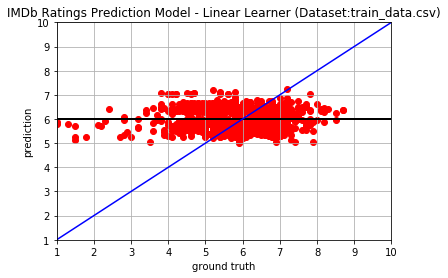

In [26]:
import matplotlib.pyplot as plt

x = preds['ground_truth']
y = preds['prediction']
plt.scatter(x, y, color="red")
plt.title(f"IMDb Ratings Prediction Model - Linear Learner (Dataset:{Train})")
plt.xlabel("ground truth")
plt.ylabel("prediction")
plt.xlim([1,10])
plt.ylim([1,10])
plt.axhline(y=6, xmin=0, xmax=10, linewidth=2, color = 'k')
plt.plot([1,10],[1,10], color="blue")
plt.grid()
plt.show()